# velocity -> permeability, porosity

The velocity and density distribution come originally from the BG Compass model. In this notebook, we will show how we build up a permeability model. This example is shown on a 2D slice.

The permeability field is usually assumed to be anistropy, i.e. permeability values in vertical direction and horizonal direction are different. In this example, we assume the Kv/Kh ratio (permeability anisotropy) is 0.4, which means that vertical permeability is 0.4 of the horizontal permeability.

In [1]:
using PyPlot, JLD2, FFTW, DSP, Images, LinearAlgebra, JUDI, PyCall, Polynomials

`DEVITO_OPENMP` is deprecated. DEVITO_LANGUAGE=openmp should be used instead
Both `DEVITO_OPENMP` and `DEVITO_LANGUAGE` set. Ignoring `DEVITO_OPENMP`


We first load the model by JLD2. This model is a part of a 2D slice from BG Compass model.

In [2]:
JLD2.@load "../model/bgSlice.jld2"

3-element Array{Symbol,1}:
 :v
 :rho
 :d

The model provided by BG Compass dataset comes with a grid spacing of 25m horizontally and 6m vertically. For accurate conversion, we first upsample the model to be 6m on both directions.

In [3]:
n = (2651, 341)
v = imresize(v,n)
rho = imresize(v,n)
d = (6f0,6f0)

(6.0f0, 6.0f0)

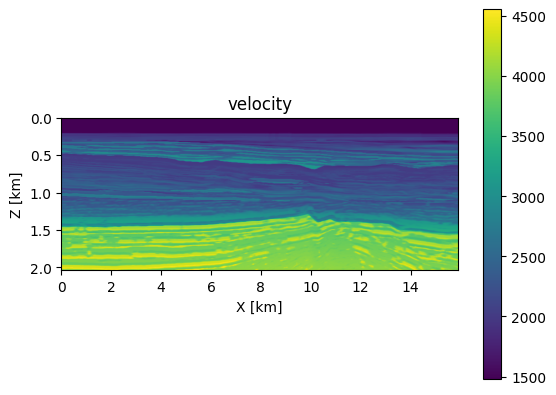

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa5104f15d0>

In [4]:
extentx = (n[1]-1)*d[1]
extentz = (n[2]-1)*d[2]
figure();imshow(v',extent=(0,extentx/1f3,extentz/1f3,0),aspect=3)
xlabel("X [km]")
ylabel("Z [km]")
title("velocity")
colorbar()

We then get the index of ocean bottom and unconformity

In [5]:
idx_wb = find_water_bottom(rho.-rho[1,1])

2651-element Array{Integer,1}:
 36
 36
 36
 36
 36
 36
 36
 36
 36
 36
 36
 36
 36
  ⋮
 37
 37
 37
 37
 37
 37
 37
 37
 37
 37
 37
 37

In [6]:
idx_ucfmt = find_water_bottom((v.-3500f0).*(v.>3500f0))

2651-element Array{Integer,1}:
 245
 245
 245
 245
 245
 245
 245
 245
 245
 245
 245
 245
 245
   ⋮
 261
 261
 261
 261
 261
 261
 261
 261
 261
 261
 261
 261

To make a proxy horizontal permeability model representative for the North Sea area, we follow the Strategic UK CCS Storage Appraisal Project report and divide the whole model into multiple regions:

On the bottom is the main reservoir location, made of high permeable sandstones (>200mD)

The 50m-depth primary seal lays over the reservoir, made of low permeable Rot Halite member (<1f-4mD)

A secondary seal is above the primary seal, made of relatively low permeable Haisborough group (15-20mD)

In each region, we assume a linear relationship between compressional wavespeed and permeability, indicated by the following article, where an increase of 1km/s in velocity corresponds to an increase of 1.03mD in permeability.

Klimentos, Theodoros. "The effects of porosity-permeability-clay content on the velocity of compressional waves." Geophysics 56.12 (1991): 1930-1939.

In [7]:
Kh = zeros(Float32, n)
for i = 1:n[1]
    Kh[i,1:idx_wb[i]-1] .= eps()  # water layer
    Kh[i,idx_wb[i]:idx_ucfmt[i]-1] .= 1.03*1f-3*v[i,idx_wb[i]:idx_ucfmt[i]-1].+15f0
    Kh[i,idx_ucfmt[i]:idx_ucfmt[i]+8] .= 1f-4
    Kh[i,idx_ucfmt[i]+9:end] .= 1.03*1f-3*v[i,idx_ucfmt[i]+9:end].+200f0
end

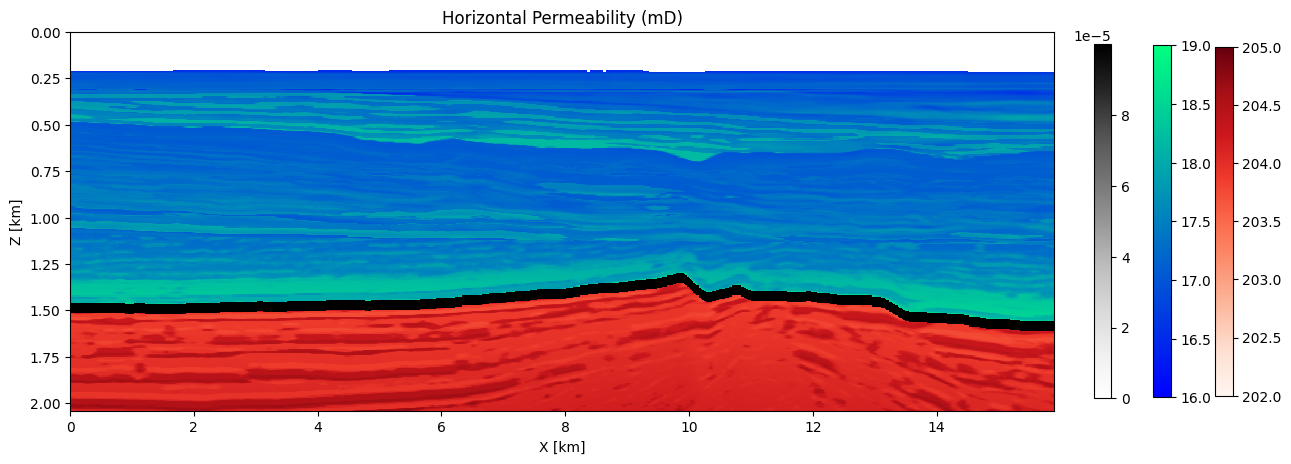

PyObject Text(0.5, 1.0, 'Horizontal Permeability (mD)')

In [8]:
@pyimport numpy.ma as ma
p1 = pycall(ma.masked_greater, Any, Kh', 50)
p2 = pycall(ma.masked_less, Any, Kh', 50)
p3 = pycall(ma.masked_greater, Any, Kh', 10)

fig,ax = PyPlot.subplots(figsize=(15,8))
pic2 = ax.imshow(p2,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Reds",vmin=202,vmax=205,aspect=3)
cb2 = colorbar(pic2,fraction=0.015, pad=0.038);
pic1 = ax.imshow(p1,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="winter",vmin=16,vmax=19,aspect=3);
cb1 = colorbar(pic1,fraction=0.016, pad=0.038);
pic3 = ax.imshow(p3,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Greys",vmin=0f0,vmax=1f-4,aspect=3)
cb3 = colorbar(pic3,fraction=0.017, pad=0.038);
xlabel("X [km]");ylabel("Z [km]");
title("Horizontal Permeability (mD)")

We assume Kv/Kh ratio is 0.4

In [9]:
Kv = 0.4*Kh

2651×341 Array{Float64,2}:
 8.88178e-17  8.88178e-17  8.88178e-17  …  81.8059  81.7938  81.6513  81.6012
 8.88178e-17  8.88178e-17  8.88178e-17     81.8059  81.7938  81.6513  81.6012
 8.88178e-17  8.88178e-17  8.88178e-17     81.8081  81.7941  81.6514  81.6014
 8.88178e-17  8.88178e-17  8.88178e-17     81.8133  81.7949  81.6516  81.6018
 8.88178e-17  8.88178e-17  8.88178e-17     81.8186  81.7956  81.6519  81.6022
 8.88178e-17  8.88178e-17  8.88178e-17  …  81.8239  81.7964  81.6521  81.6026
 8.88178e-17  8.88178e-17  8.88178e-17     81.8292  81.7971  81.6523  81.603
 8.88178e-17  8.88178e-17  8.88178e-17     81.8344  81.7979  81.6525  81.6034
 8.88178e-17  8.88178e-17  8.88178e-17     81.8397  81.7987  81.6527  81.6038
 8.88178e-17  8.88178e-17  8.88178e-17     81.845   81.7994  81.6529  81.6042
 8.88178e-17  8.88178e-17  8.88178e-17  …  81.8499  81.8002  81.6531  81.6051
 8.88178e-17  8.88178e-17  8.88178e-17     81.8514  81.8006  81.6533  81.6104
 8.88178e-17  8.88178e-17  8.88178e-17

To convert horizontal permeability to porosity, we follow Kozeny-Carman relationship

$$K = \mathbf{\phi}^3 \left(\frac{1.527}{0.0314*(1-\mathbf{\phi})}\right)^2$$

At the primary seal location, we assume the porosity decreases from 10% to 5.6%.

In [10]:
phi = zeros(Float32,n)
for i = 1:n[1]
    for j = 1:n[2]
        p = Polynomial([-0.0314^2*Kh[i,j],2*0.0314^2*Kh[i,j],-0.0314^2*Kh[i,j],1.527^2])
        phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
    end
    for j = idx_ucfmt[i]:idx_ucfmt[i]+8
        phi[i,idx_ucfmt[i]:idx_ucfmt[i]+8] = Float32.(range(0.056,stop=0.1,length=9))
    end
end

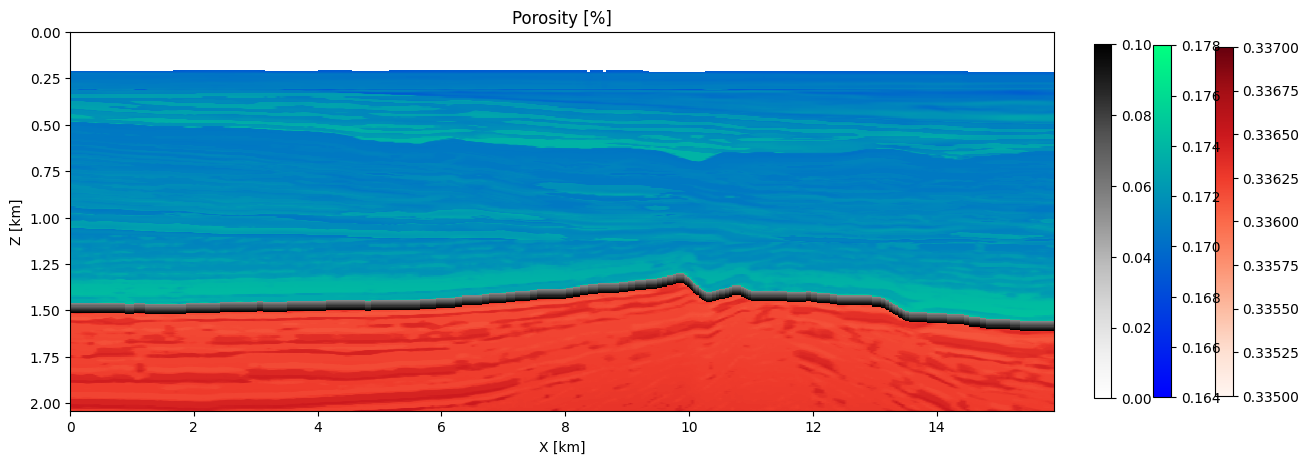

PyObject Text(0.5, 1.0, 'Porosity [%]')

In [11]:
@pyimport numpy.ma as ma
p1 = pycall(ma.masked_greater, Any, phi', 0.3)
p2 = pycall(ma.masked_less, Any, phi', 0.3)
p3 = pycall(ma.masked_greater, Any, phi', 0.11)

fig,ax = PyPlot.subplots(figsize=(15,8))
pic2 = ax.imshow(p2,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Reds",vmin=0.335,vmax=0.337,aspect=3)
cb2 = colorbar(pic2,fraction=0.015, pad=0.038);
pic1 = ax.imshow(p1,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="winter",vmin=0.164,vmax=0.178,aspect=3);
cb1 = colorbar(pic1,fraction=0.016, pad=0.038);
pic3 = ax.imshow(p3,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Greys",vmin=0f0,vmax=0.1f0,aspect=3)
cb3 = colorbar(pic3,fraction=0.017, pad=0.038);
xlabel("X [km]");ylabel("Z [km]");
title("Porosity [%]")